# Lab Tutorial 06 (Solved)

- **Module:** Computer Vision - IN3060/INM460
- **Module leader:** [Giacomo Tarroni](mailto:giacomo.tarroni@city.ac.uk)

# Google Colab Setup
Before starting the tutorial, we need to run a few commands to set up our environment on Google Colab. To this end, make sure to have first gone through the **"Software setup guide"** document uploaded on Moodle. Also, if you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store the lab materials for this tutorial!), and follow the instructions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded the lab materials, fill it in below and run the cell:

In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision lab tutorials/Lab 06' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['ClassLarge.jpg', 'Code', 'Lab_06.ipynb', 'Lab_06_Solved.ipynb']


If everything is working correctly then running the folowing cell should print the filenames from the lab materials folder:

```
['ClassLarge.jpg', 'Code', 'Lab_06.ipynb', 'Lab_06_Solved.ipynb']
```

Note that `Code` is actually a folder: it would be nice to now what its content is. 

You can easily **explore the content of your Google Drive folder** (which is now visible in Colab) by clicking on the *Files* folder in the toolbar on the left side and expanding the *drive* folder. If you follow the path to your `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` folder, you will see that `Code` contains a single file called `train_SVM.py`, which we will use in one of the tasks. 

**Important**: to properly run .py source files from outside the Colab notebook, it's important to load the `autoreload` extension. This allows us to automatically re-import the files into the notebook for a seamless editing and debugging experience, and can be easily achieved with the following code:

In [ ]:
%load_ext autoreload
%autoreload 2

We will also add the `Code` folder to our PATH, to make importing the functions in `train_SVM.py` easier:

In [ ]:
import sys
CODE_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Code')
sys.path.append(CODE_PATH)

# Introduction

In this lab tutorial, we will implement our first **image classifier using Support Vector Machines (SVMs)**. In particular, we will focus on the very famous **MNIST digit dataset**. Then, we will test a **cascade classifier for face detection** and use it to automate a task that we performed manually in a previous lab (i.e. blurring the faces in a class photo). Finally, we will see how to extract **histograms of gradients (HOGs)** features from an image.

# 1: Digit classification with Support Vector Machines (SVMs)

Adapted from [here](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html).

In the lecture, we have described **support vector machines**, which are a very powerful classification algorithm that can be used for **image classification**. In this part of the tutorial, we will attempt to train an SVM on the **MNIST dataset of digits** and see how it performs. 

Note that **we will use simple pixel intensities as feature descriptors**: since each image in MNIST is 28x28 pixels, we will therefore use a 784-dimensional feature descriptors. This is not perhaps the smartest choice, but it's worth using it as a starting point.

The MNIST dataset is conveniently pre-loaded in each Colab instance (you can see it in the `sample_data` folder using the toolbar on the left). In particular, there are two files called `mnist_train_small.csv` and `mnist_test.csv`: for both, each row corresponds to a single sample (i.e. the image showing the digit), where the first number is the label (from 0 to 9) and the other 784 are the actual pixel values (from 0 to 255). 

Let's start by loading the training data and labels in two separate arrays and converting the pixel values to float. Note that in this case we will use `numpy`'s `astype` method instead of `skimage` functions because the data is not encoded into actual image files. 

In [ ]:
from sklearn import svm, metrics
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

train_data = np.genfromtxt('sample_data/mnist_train_small.csv', delimiter=",")
X_train = train_data[:, 1:]
y_train = train_data[:, 0]

# Rescale the intensities, cast the labels to int
X_train = X_train / 255.
y_train = y_train.astype(int)

print('X_train shape =', X_train.shape)
print('y_train shape =', y_train.shape)

X_train shape = (20000, 784)
y_train shape = (20000,)


As you can see, we have 20000 samples in the training set. Let's reduce this a bit to enable faster computing (but potentially lowering the accuracy of our model):

In [ ]:
n_train_samples = 2000
X_train = X_train[:n_train_samples]
y_train = y_train[:n_train_samples]

Let's now see how the data appears by reshaping the first few samples into 28x28 pixels images:

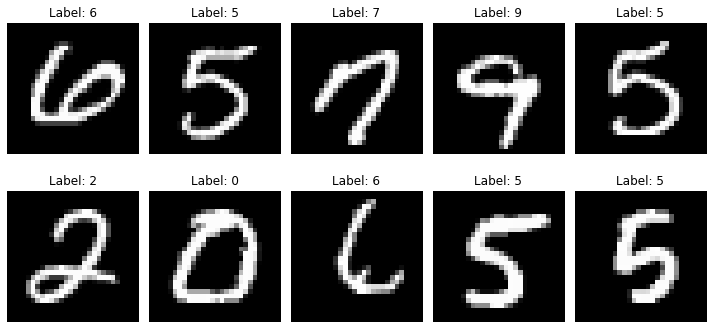

In [ ]:
X_train_img = X_train.reshape(-1, 28, 28)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_train_img[i, :, :], cmap='gray')
    ax[i].set_title(f'Label: {y_train[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

Notice how some digits are not that easy to interpret (e.g. the '7' and the 2nd '6'). Exploring the data is always extremely important as it allows to assess potential issues and problems before blaiming a low accuracy on the training algorithm.

Let's now create an SVM classifier object using the `sklearn` library, and use the `fit` method to train it on the available dataset:

In [ ]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Train the classifier
classifier.fit(X_train, y_train)

SVC(gamma=0.001)

That was easy! However you might want to search the documentation to understand what the parameter `gamma` means.

Now it's time to check how this classifier performs on the test set. Let's load and rescale it first:

In [ ]:
test_data = np.genfromtxt('sample_data/mnist_test.csv', delimiter=",")
X_test = test_data[:, 1:]
y_test = test_data[:, 0]

# Rescale the intensities, cast the labels to int
X_test = X_test / 255.
y_test = y_test.astype(int)

We can now predict the classes on the images of the test set using the `predict` method:

In [ ]:
y_pred = classifier.predict(X_test)

Let's check the result qualitatively on a small (and **randomly shuffled**) subset of the test set:

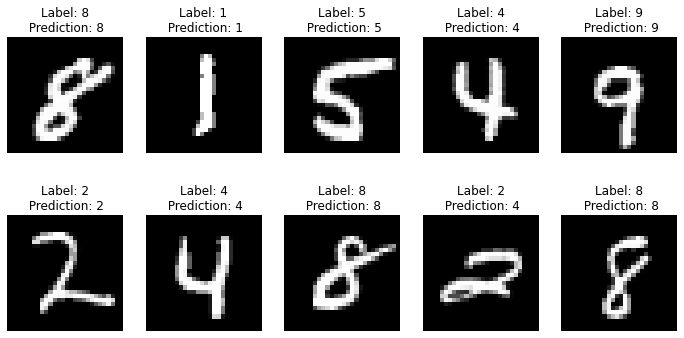

In [ ]:
X_test, y_test, y_pred = shuffle(X_test, y_test, y_pred)
X_test_img = X_test.reshape(-1, 28, 28)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test_img[i, :, :], cmap='gray')
    ax[i].set_title(f'Label: {y_test[i]}\n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout
plt.show()

Note that you can run the previous cell multiple times to inspect other images from the test set, which is very convenient.

But what about the overall performance on the whole test set? The first thing to check is the confusion matrix, which we can easily extract and display using functions from the `sklearn.metrics` sub-module:

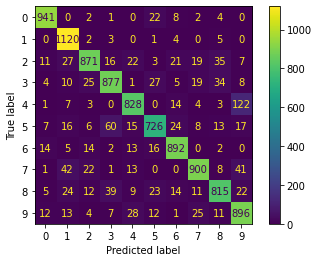

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

This looks good: as you can see, most entries are in the main diagonal of the confusion matrix, meaning that most predictions were correct. 

While the confusion matrix helps a lot to evaluate a classifier, it's not very straightforward to interpret. We can actually extract performance metrics from it using a very handy function from `sklearn.metrics` called `classification_report`:

In [ ]:
print(f"""Classification report for classifier {classifier}:\n
      {metrics.classification_report(y_test, y_pred)}""")

Classification report for classifier SVC(gamma=0.001):

                    precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.89      0.99      0.93      1135
           2       0.91      0.84      0.87      1032
           3       0.87      0.87      0.87      1010
           4       0.89      0.84      0.87       982
           5       0.87      0.81      0.84       892
           6       0.91      0.93      0.92       958
           7       0.91      0.88      0.89      1028
           8       0.88      0.84      0.86       974
           9       0.81      0.89      0.84      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.88      0.89     10000
weighted avg       0.89      0.89      0.89     10000



As you can see, the accuracy is around 0.89, meaning that our classifier is roughly right in the test set 9 out of 10 times. Not bad considering the type of feature descriptors that we have used!

Do you understand all the metrics presented in the classification report? Make sure you do by double-checking the lecture's materials and the function's documentation (which you can find online).

## Task 1.1: Implementing a different type of SVM

As we have seen in the lecture, SVMs can be implemented using different kernel functions. **Implement a few different kernel functions** (including the linear one) **and compare their performance** on the MNIST dataset. You can also change the relative hyper-parameters, including `C`.

Differently from what we have done so far, you will need to implement the different types of SVMs using the `train_SVM.py` file in the `Code` folder. This is technically useless in this case, but in the future it will turn out to be very useful. You can open the file by clicking on it using the folder structure accessible from the toolbar on the left. Implement one or more functions there that will train and return a classifier object, and then call the function(s) in the cell below. Start by defining a function called `train_linear_SVM`, which should implement a linear kernel. Make sure that the trained classifier is named `classifier_new`.

In [ ]:
from train_SVM_solved import train_linear_SVM

##############################################################################
# TODO: Implementing a different type of SVM                                 #
##############################################################################
classifier_new = train_linear_SVM(X_train, y_train)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Now assess the accuracy of your classifier both qualitatively and quantitatively:

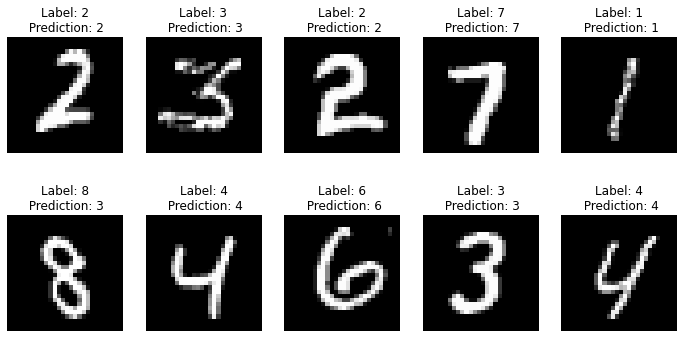

Classification report for classifier SVC(kernel='linear'):

                    precision    recall  f1-score   support

           0       0.92      0.98      0.95       980
           1       0.95      0.97      0.96      1135
           2       0.90      0.89      0.89      1032
           3       0.86      0.87      0.86      1010
           4       0.91      0.90      0.90       982
           5       0.85      0.85      0.85       892
           6       0.93      0.95      0.94       958
           7       0.92      0.91      0.91      1028
           8       0.89      0.83      0.86       974
           9       0.88      0.87      0.88      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
y_pred_new = classifier_new.predict(X_test)

# Check qualitative result on small (shuffled) subset
X_test, y_test, y_pred_new = shuffle(X_test, y_test, y_pred_new)
X_test_img = X_test.reshape(-1, 28, 28)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test_img[i, :, :], cmap='gray')
    ax[i].set_title(f'Label: {y_test[i]}\n Prediction: {y_pred_new[i]}')
    ax[i].set_axis_off()
fig.tight_layout
plt.show()

print(f"""Classification report for classifier {classifier_new}:\n
      {metrics.classification_report(y_test, y_pred_new)}""")

Did you manage to improve on the result obtained with the default SVM settings?

## Task 1.2: Using more training samples

Change the parameter `n_train_samples`: what is the impact on the accuracy?

# 2: Testing a cascade classifier for face detection

In today’s lecture we have introduced the famous **Viola-Jones object detector** framework, which was originally used for face detection. `OpenCV` has a specific object for this framework called `CascadeClassifier`, that also comes with [several pre-trained models](https://github.com/opencv/opencv/tree/master/data/haarcascades).

Let's try and test one of them on a group photo from a previous year's class of this module, which we can load running the following cell:

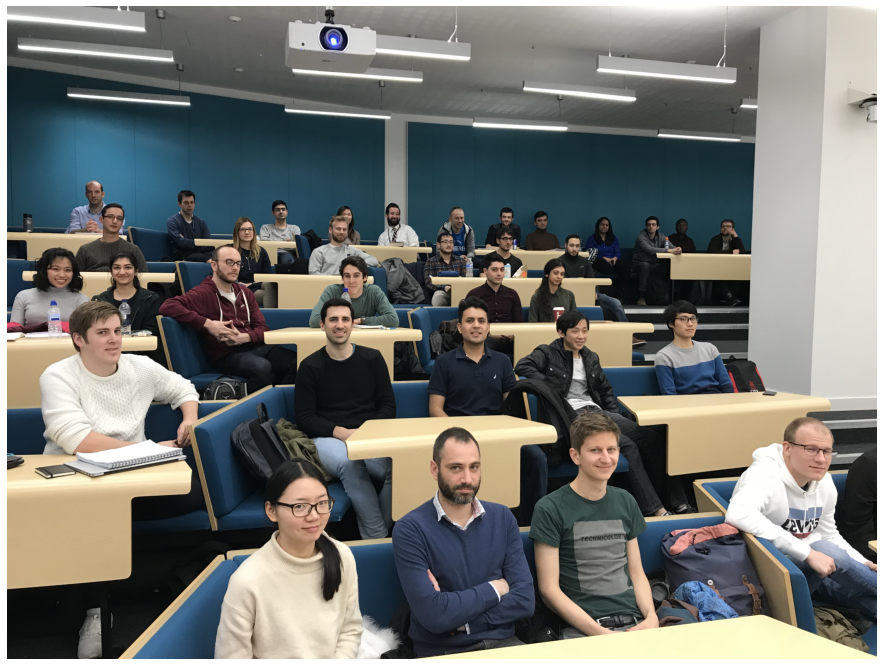

In [ ]:
from skimage import io, color, img_as_ubyte
import cv2
import matplotlib.pyplot as plt
from matplotlib import patches

img = io.imread(os.path.join(GOOGLE_DRIVE_PATH, 'ClassLarge.jpg'))
img_gray = color.rgb2gray(img)
img_gray = img_as_ubyte(img_gray)         # Conversion required by OpenCV

fig, ax = plt.subplots(figsize=(18, 12))
ax.imshow(img), ax.set_axis_off()
fig.tight_layout
plt.show()

Now let's load the `haarcascade_frontalface_default.xml` model into a `CascadeClassifier` object and test it on the image. Make sure to understand both the input arguments and the generated output for the `detectMultiScale` method by looking at the online documentation.

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)
print('faces shape =', faces.shape)

faces shape = (31, 4)


In particular, `faces` is an array of coordinates of bounding boxes relative to the faces detected in the image. Based on its shape, we can say that the detector has identified 31 faces in the image. Let's plot them using `matplotlib.patches`:

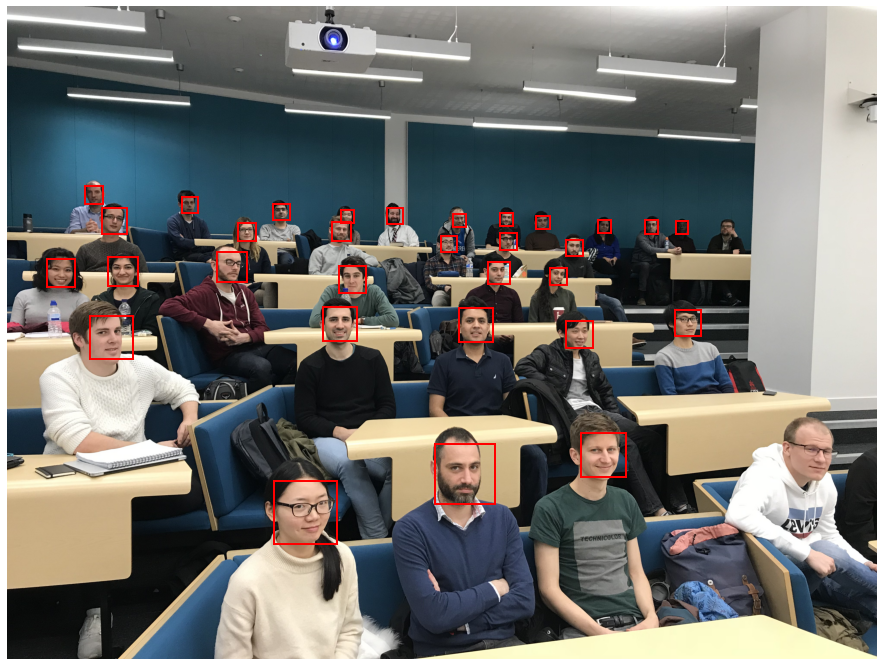

In [ ]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.imshow(img), ax.set_axis_off()

for face in faces:
    ax.add_patch(
        patches.Rectangle(xy=(face[0], face[1]), width=face[2], height=face[3],
                          fill=False, color='r', linewidth=2))
fig.tight_layout
plt.show()

## Task 2.1: Automatically blur faces

If you remember, in a previous lab tutorial you were asked to blur the faces in the image `Class.jpg`. That time, I had provided you the coordinates of the bounding boxes of a few faces after inspecting the image with my cursor. **Repeat the same exercise**, but this time **using a pre-trained** `CascadeClassifier` **face detector**. Make sure that the final image is called `img_composite`.

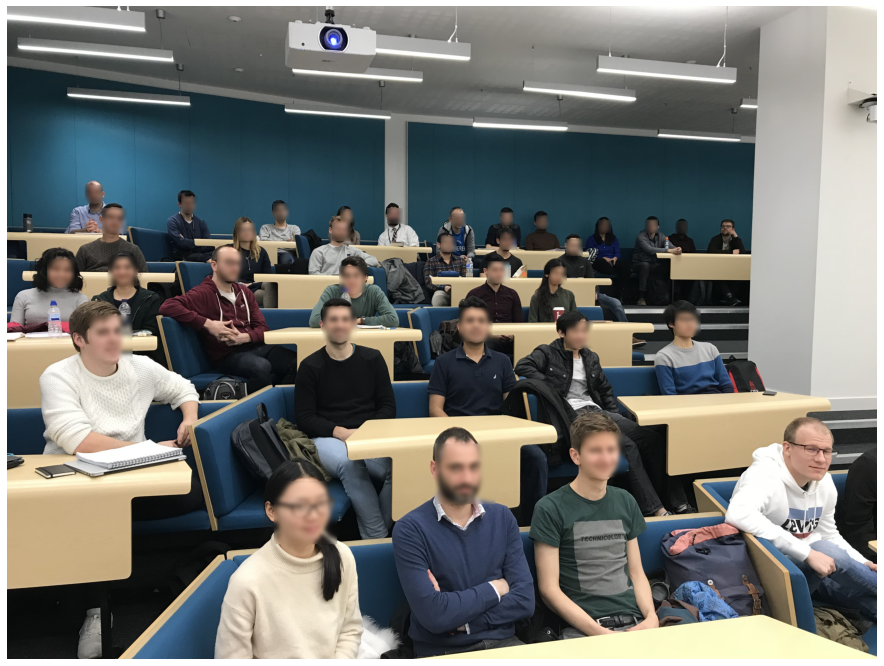

In [ ]:
##############################################################################
# TODO: Automatically blur faces                                             #
##############################################################################
from skimage import filters

img_blurred = img_as_ubyte(filters.gaussian(img, sigma=10, multichannel=True))
img_composite = img.copy()

for face in faces:
    img_composite[face[1]:face[1]+face[3], face[0]:face[0]+face[2], :] = \
        img_blurred[face[1]:face[1]+face[3], face[0]:face[0]+face[2], :]
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

fig, ax = plt.subplots(figsize=(18, 12))
ax.imshow(img_composite), ax.set_axis_off()
fig.tight_layout
plt.show()

## Task 2.2: Break the detector

Can you **resize the image in a way that breaks the detector**? Use the function [`skimage.transform.rescale`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rescale) as pre-processing to the image (make sure you use set the `multichannel` and `anti_aliasing` parameters properly, and cast the output as uint8). 

Then, feel free to also play with the [`detectMultiScale`](https://docs.opencv.org/4.4.0/d1/de5/classcv_1_1CascadeClassifier.html#aaf8181cb63968136476ec4204ffca498) parameters to **see if you can fix the detector** back.

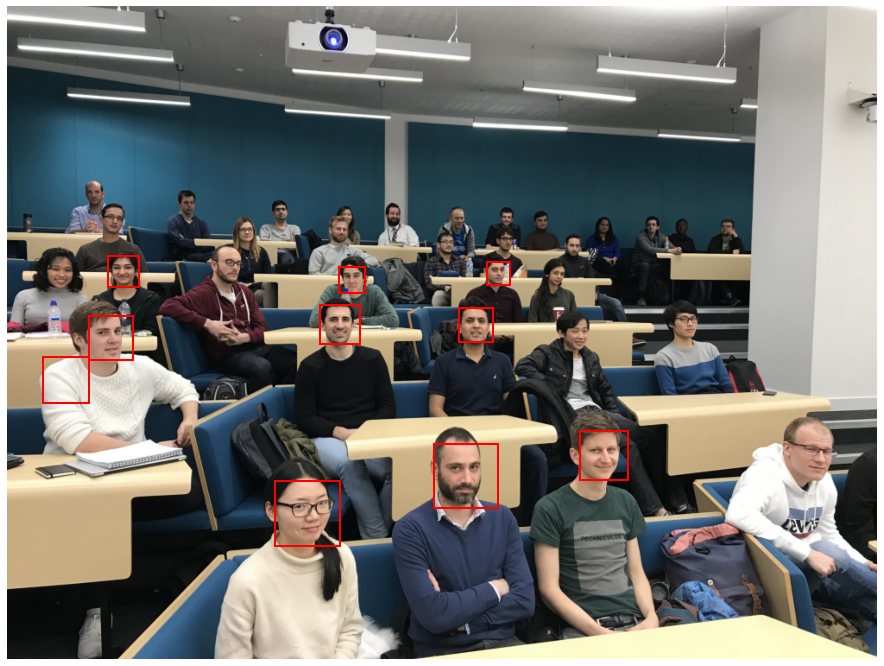

In [ ]:
##############################################################################
# TODO: Break the detector
##############################################################################
from skimage import transform

img = img_as_ubyte(transform.rescale(img, 0.25, multichannel=True, anti_aliasing=True))
img_gray = color.rgb2gray(img)
img_gray = img_as_ubyte(img_gray)         # Conversion required by OpenCV

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(img_gray, 1.3, 5)

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

fig, ax = plt.subplots(figsize=(18, 12))
ax.imshow(img), ax.set_axis_off()

for face in faces:
    ax.add_patch(
        patches.Rectangle(xy=(face[0], face[1]), width=face[2], height=face[3],
                          fill=False, color='r', linewidth=2)
    )
fig.tight_layout
plt.show()

# 3: Extract HOG feature descriptors

Adapted from [here](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html#sphx-glr-auto-examples-features-detection-plot-hog-py).

In the lecture, we have described the histograms of gradients (HOGs) feature descriptor. This descriptor can be extremely powerful to distinguish different shapes in images. 

Let's learn how to extract HOGs from a sample image using the `skimage.feature.hog` function:

In [ ]:
from skimage.feature import hog
from skimage import data, exposure
import matplotlib.pyplot as plt

image = data.astronaut()

HOG_des, HOG_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=2)

The HOG descriptor is stored in the `HOG_des` variable, which has the following number of dimensions for the given settings:

In [ ]:
print('HOG descriptor shape =', HOG_des.shape)

HOG descriptor shape = (8192,)


If `skimage.feature.hog` is called with `visualize=True`, then a visualisation of the feature descriptor is also created (here called `HOG_image`):

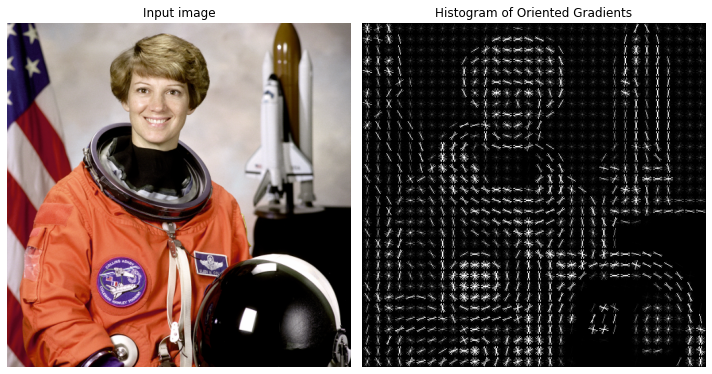

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)

ax[0].axis('off')
ax[0].imshow(image)
ax[0].set_title('Input image')

# Rescale histogram for better display
HOG_image_rescaled = exposure.rescale_intensity(HOG_image, in_range=(0, 10))

ax[1].axis('off')
ax[1].imshow(HOG_image_rescaled, cmap='gray')
ax[1].set_title('Histogram of Oriented Gradients')
fig.tight_layout()
plt.show()

**Note that this image is generated only to better understand what is the information stored in the HOG descriptor.** As we have just seen, the actual descriptor is an array of 8192 elements.